# hw2: Решающие деревья

*Спасибо великому курсу великого Евгения Соколова*

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплементацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

Все данные, на которых будут обучаться модели, вы можете найти на диске.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw2-trees.ipynb``` и модуль с реализованными функциями и классами ```hw2code.py``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце <<hw2>> в строке со своей фамилией о том, что вы выполнили работу с указанием ника на Kaggle.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [ ]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0, )
]

In [ ]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

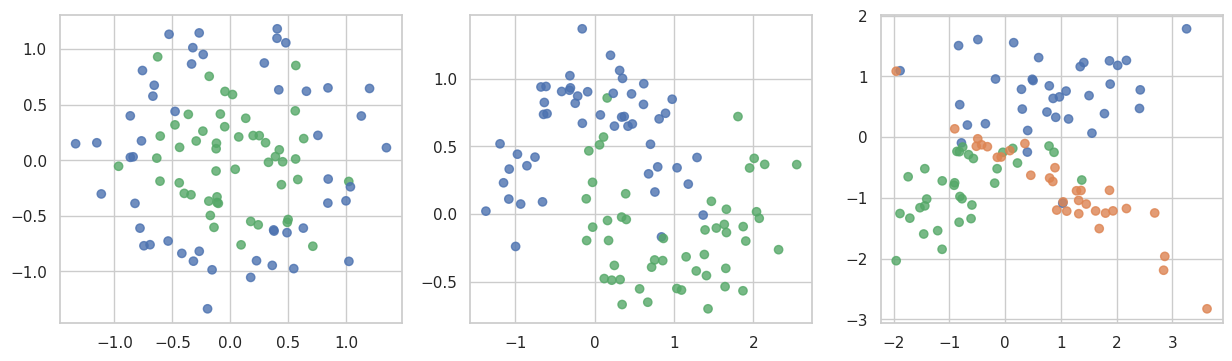

In [ ]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [ ]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

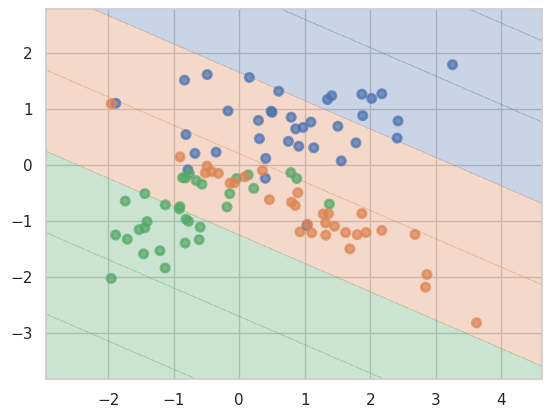

In [ ]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

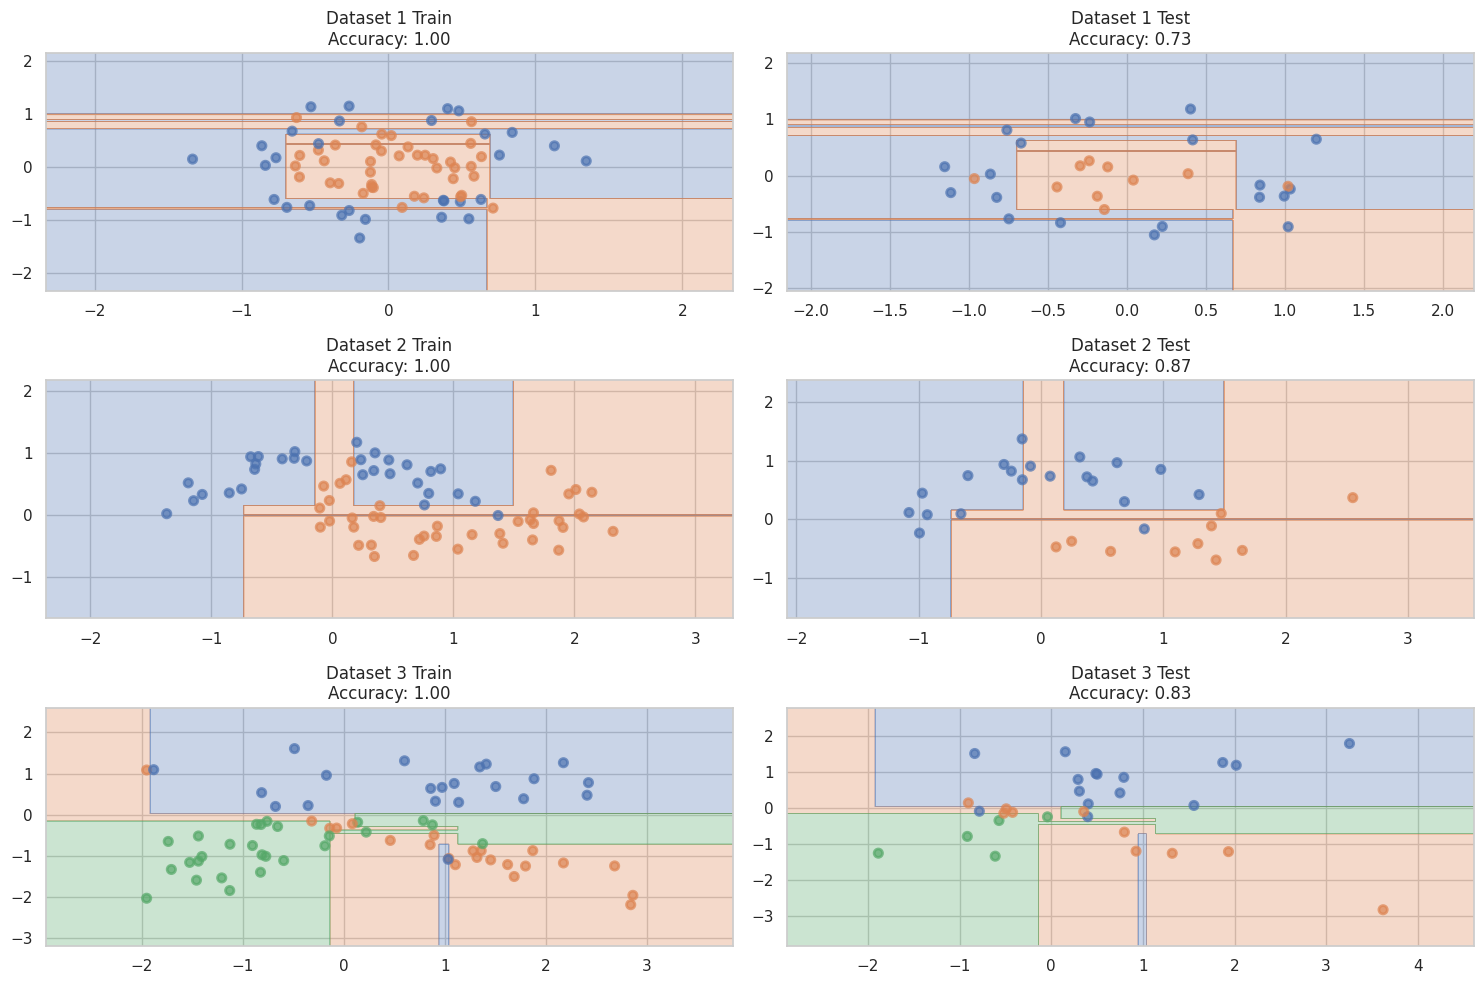

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

plt.figure(figsize=(15, 10))

for i, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    tree = DecisionTreeClassifier(random_state=42)
    tree.fit(X_train, y_train)

    train_pred = tree.predict(X_train)
    test_pred = tree.predict(X_test)

    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)

    plt.subplot(3, 2, 2*i+1)
    plot_surface(tree, X_train, y_train)
    plt.title(f'Dataset {i+1} Train\nAccuracy: {train_acc:.2f}')

    plt.subplot(3, 2, 2*i+2)
    plot_surface(tree, X_test, y_test)
    plt.title(f'Dataset {i+1} Test\nAccuracy: {test_acc:.2f}')

plt.tight_layout()
plt.show()

__Ответ:__ склонность к переобучению из за маленькой выборки



__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

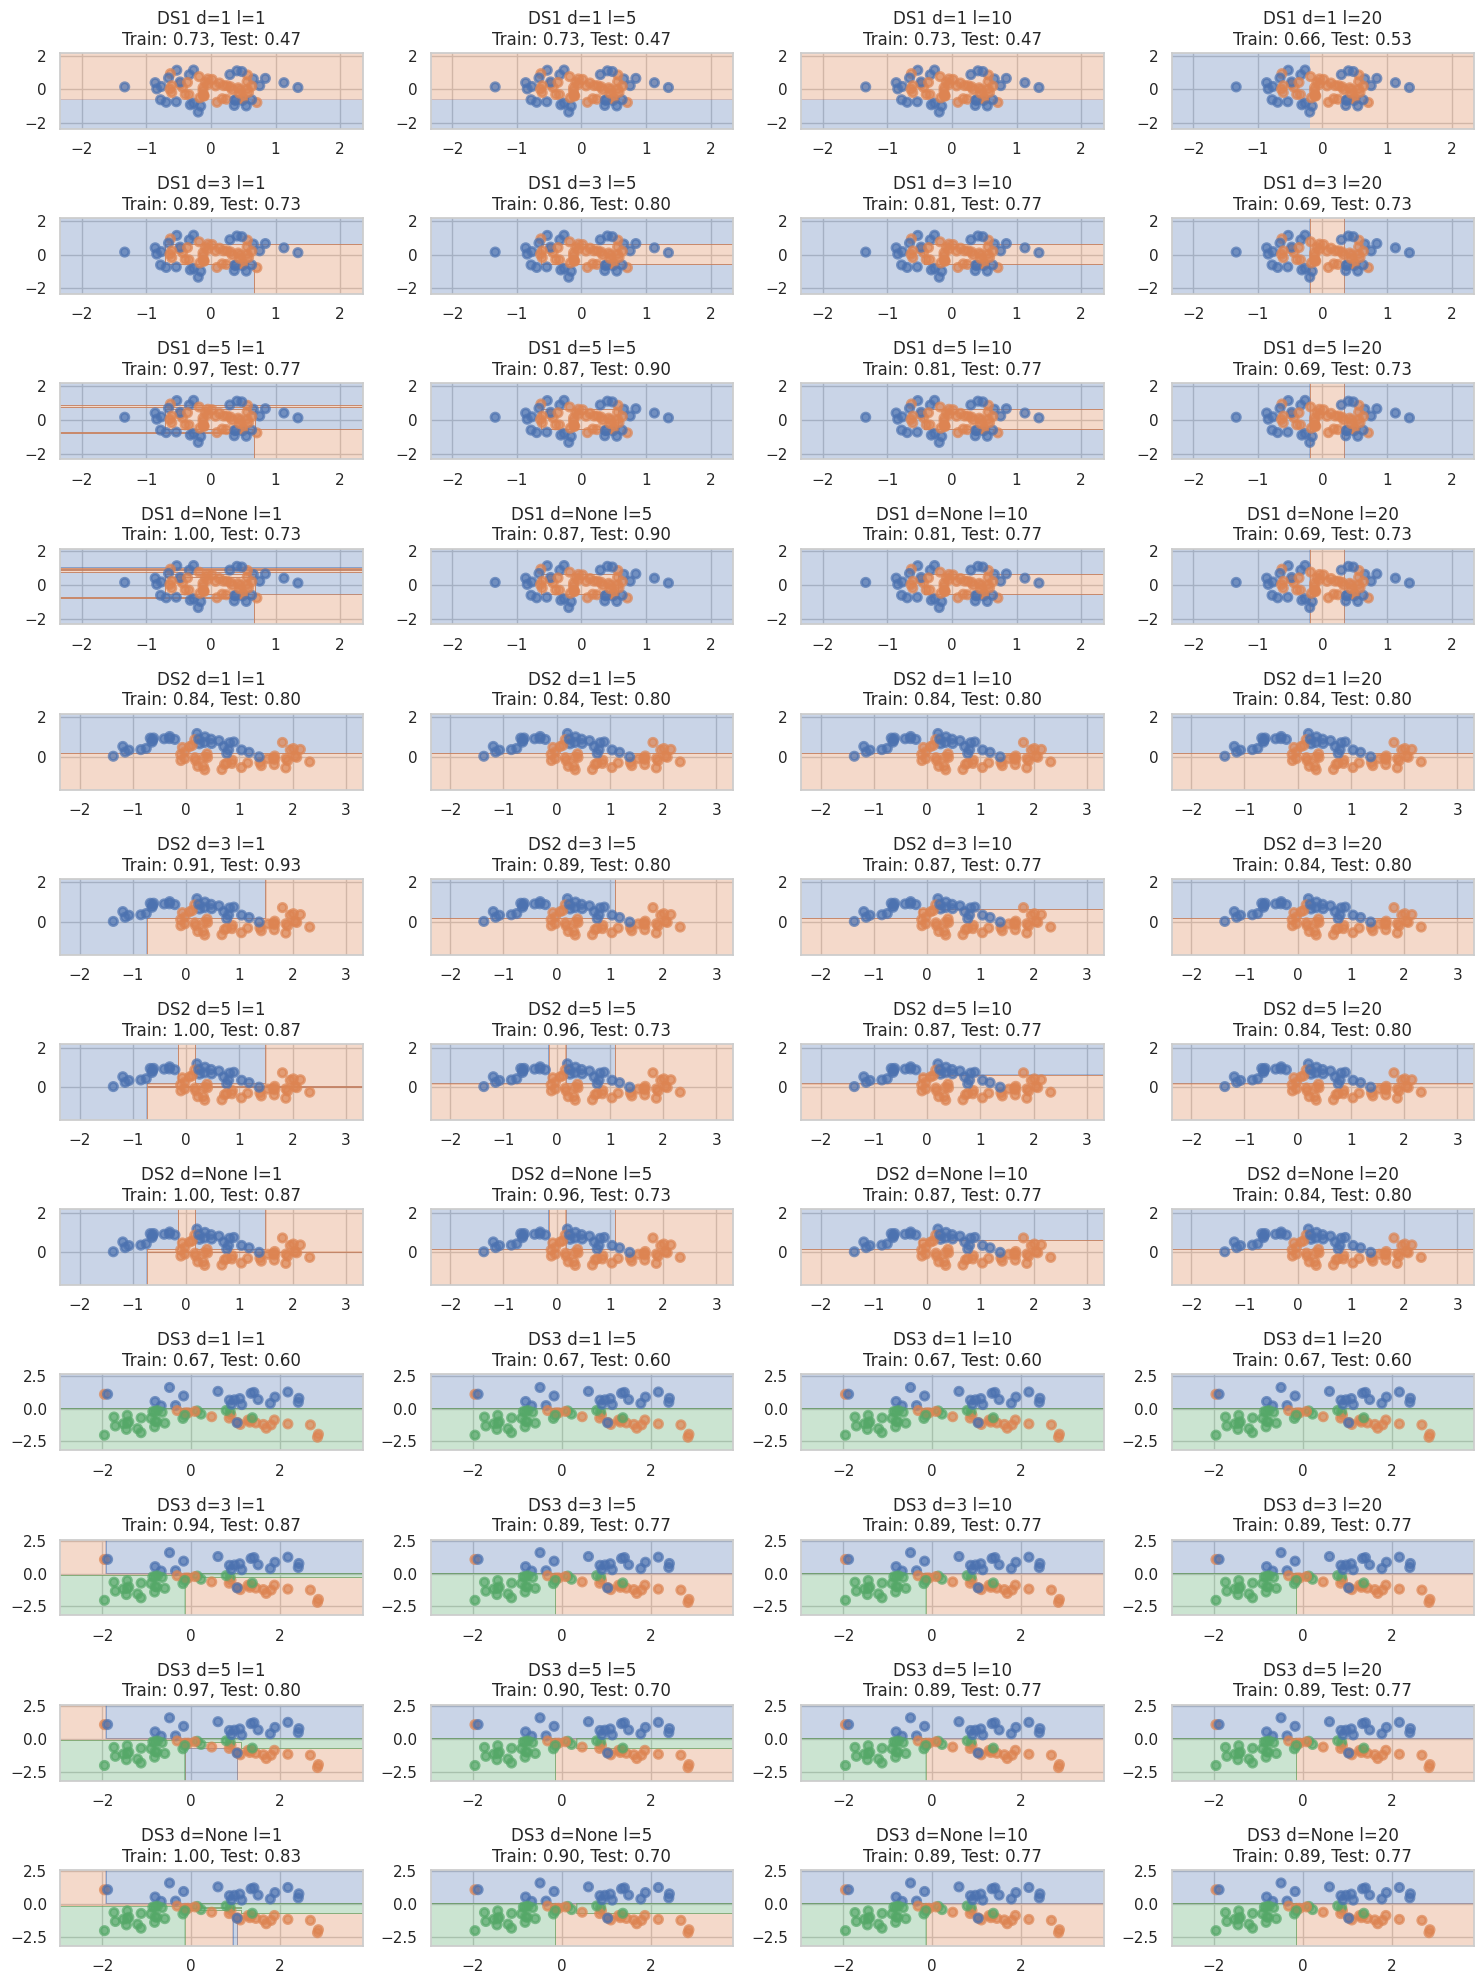

In [ ]:
from sklearn.model_selection import train_test_split

max_depths = [1, 3, 5, None]
min_samples_leaves = [1, 5, 10, 20]

plt.figure(figsize=(15, 20))

for dataset_idx, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    for i, max_depth in enumerate(max_depths):
        for j, min_samples_leaf in enumerate(min_samples_leaves):
            tree = DecisionTreeClassifier(
                max_depth=max_depth,
                min_samples_leaf=min_samples_leaf,
                random_state=42
            )
            tree.fit(X_train, y_train)

            train_acc = tree.score(X_train, y_train)
            test_acc = tree.score(X_test, y_test)

            plt_idx = (dataset_idx * len(max_depths) * len(min_samples_leaves) +
                      i * len(min_samples_leaves) + j + 1)
            plt.subplot(len(datasets)*len(max_depths), len(min_samples_leaves), plt_idx)

            plot_surface(tree, X_train, y_train)
            plt.title(f'DS{dataset_idx+1} d={max_depth} l={min_samples_leaf}\n'
                     f'Train: {train_acc:.2f}, Test: {test_acc:.2f}')

plt.tight_layout()
plt.show()

__Ответ:__Оптимальные параметры зависят от сложности данных лля простых  (3) достаточно простых деревьев для сложных нелинейных  (1-2) нужны глубокие деревья с умеренной регуляризацией тк слишком сильная регуляризация приводит к недообучению, слабая к переобучению

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw2code.py

__Задание 4. (0.5 балла)__

Загрузите таблицу students.csv (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

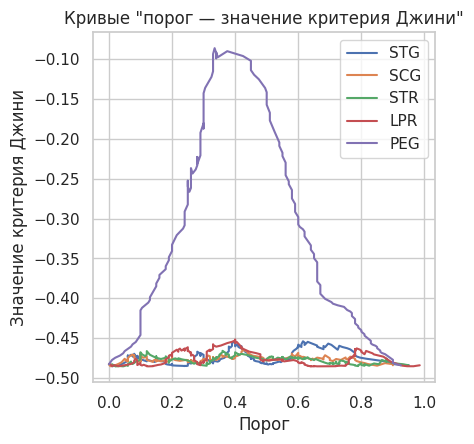

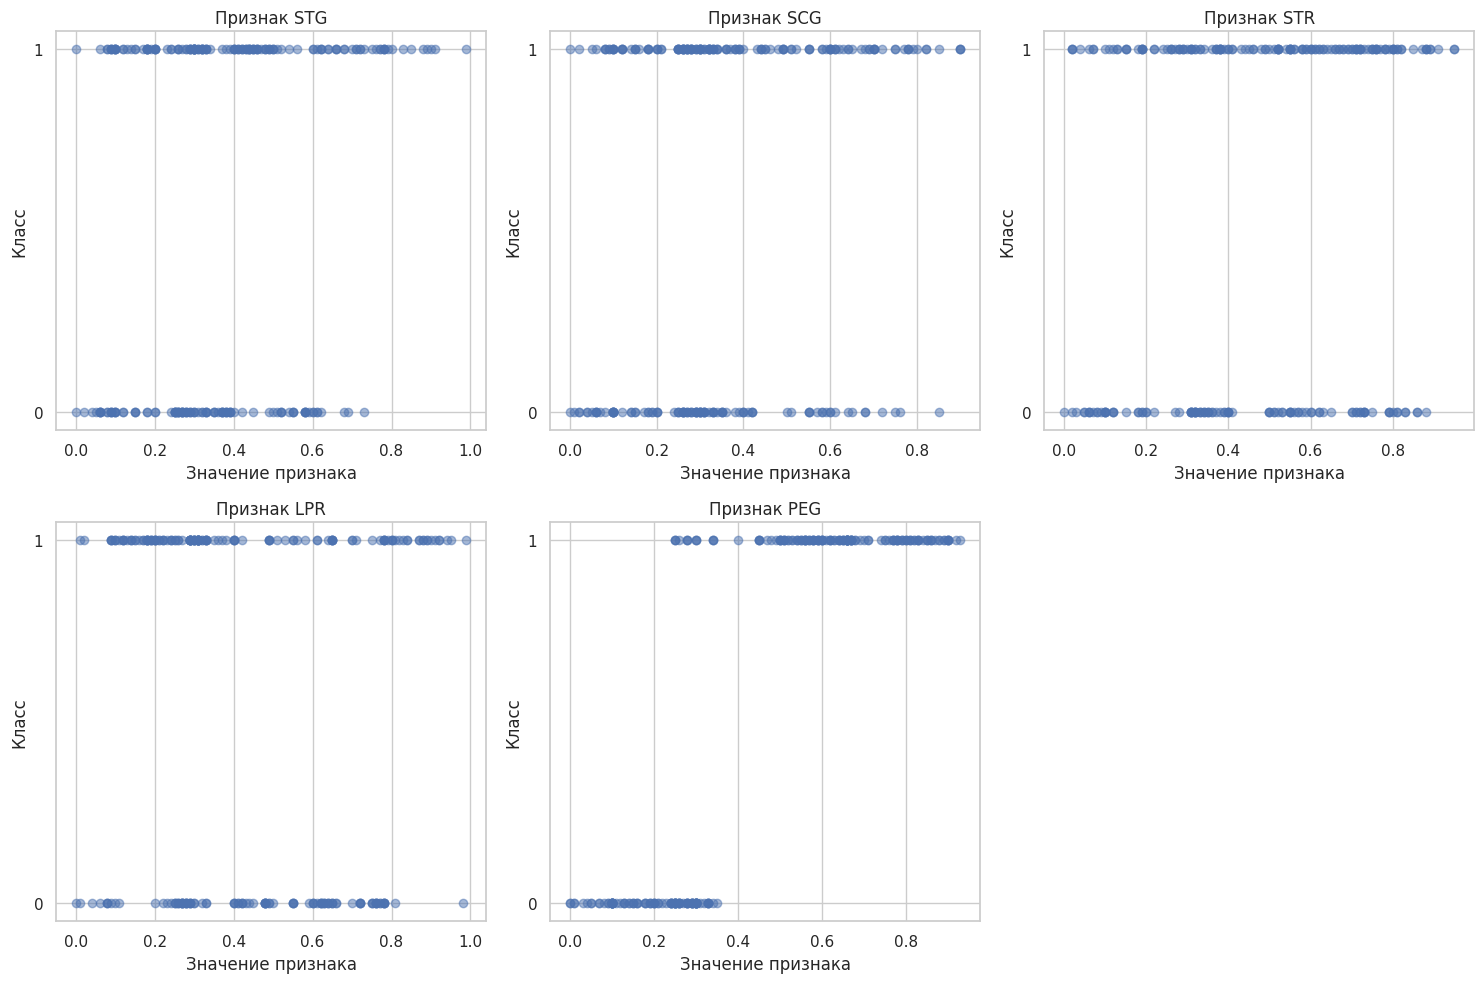

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from hw2code import find_best_split

data = pd.read_csv('students.csv')
features = data.iloc[:, :5]
target = data.iloc[:, 5]

plt.figure(figsize=(15, 10))

for i, feature_name in enumerate(features.columns):
    feature_vector = features[feature_name].values
    target_vector = target.values

    thresholds, ginis, _, _ = find_best_split(feature_vector, target_vector)

    if thresholds is not None:
        plt.subplot(2, 3, 1)
        plt.plot(thresholds, ginis, label=feature_name)
        plt.title('Кривые "порог — значение критерия Джини"')
        plt.xlabel('Порог')
        plt.ylabel('Значение критерия Джини')
        plt.legend()

plt.figure(figsize=(15, 10))

for i, feature_name in enumerate(features.columns):
    plt.subplot(2, 3, i+1)
    plt.scatter(features[feature_name], target, alpha=0.5)
    plt.title(f'Признак {feature_name}')
    plt.xlabel('Значение признака')
    plt.ylabel('Класс')
    plt.yticks([0, 1])

plt.tight_layout()
plt.show()

__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:** Лучший  для разбиения PEG (наибольший пик Джини -0.1) это и есть хороший график, плохие плоские по значению -0.5 -0.45 без явных пиков, на scatter расклад такой же, явное деление по класам тольно y PEG

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw2code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции. Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (лежит на гитхабе вместе с заданием), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
import importlib
import hw2code
importlib.reload(hw2code)
from hw2code import DecisionTree


data = pd.read_csv('agaricus-lepiota.data', header=None)

le = LabelEncoder()
encoded_data = data.apply(le.fit_transform)

X = encoded_data.iloc[:, 1:].values
y = encoded_data.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

feature_types = ['categorical'] * X.shape[1]
tree = DecisionTree(feature_types=feature_types, max_depth=5)
tree.fit(X_train, y_train)

predictions = tree.predict(X_test)
accuracy = np.mean(predictions == y_test)
print(f"Accuracy: {accuracy:.4f}")

def get_tree_depth(node):
    if node['type'] == 'terminal':
        return 0
    return 1 + max(get_tree_depth(node['left_child']),
                   get_tree_depth(node['right_child']))

print(f"Tree depth: {get_tree_depth(tree._tree)}")

Accuracy: 0.9998
Tree depth: 5


__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names):
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце)
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце, датасет лежит на гитхабе вместе с заданием)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [5]:
import pandas as pd
import numpy as np
import sklearn.preprocessing as sk_pre
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import hw2code
from hw2code import DecisionTree

def load_datasets():
    mushrooms = pd.read_csv('agaricus-lepiota.data', header=None)
    tic_tac_toe = pd.read_csv('tic-tac-toe-endgame.csv')
    cars = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', header=None)
    nursery = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data', header=None)

    return {
        'mushrooms': (mushrooms, 0),
        'tic_tac_toe': (tic_tac_toe, -1),
        'cars': (cars, -1),
        'nursery': (nursery, -1)
    }

def prepare_data(datasets):
    target_mapping = {
        'mushrooms': {'p': 0, 'e': 1},
        'tic_tac_toe': {'negative': 0, 'positive': 1},
        'cars': {'unacc': 0, 'acc': 0, 'good': 1, 'vgood': 1},
        'nursery': {'not_recom': 0, 'recommend': 0, 'very_recom': 1, 'priority': 1, 'spec_prior': 1}
    }

    encoder = sk_pre.LabelEncoder()

    for name, (df, target_idx) in datasets.items():
        target_col = df.columns[target_idx]
        df[target_col] = df[target_col].map(target_mapping[name])

        for col in df.columns:
            if col != target_col:
                df[col] = encoder.fit_transform(df[col])

    return datasets

class BaseTree:
    def _ensure_numpy(self, data):
        if hasattr(data, 'values'):
            return data.values
        return np.array(data)

class RealDecisionTree(BaseTree):
    def fit(self, X, y):
        X = self._ensure_numpy(X)
        y = self._ensure_numpy(y)
        self._tree = DecisionTree(['real'] * X.shape[1])
        self._tree.fit(X, y)

    def predict(self, X):
        X = self._ensure_numpy(X)
        return self._tree.predict(X)

    def get_params(self, deep=True):
        return {}

class CategoricalDecisionTree(BaseTree):
    def fit(self, X, y):
        X = self._ensure_numpy(X)
        y = self._ensure_numpy(y)
        self._tree = DecisionTree(['categorical'] * X.shape[1])
        self._tree.fit(X, y)

    def predict(self, X):
        X = self._ensure_numpy(X)
        return self._tree.predict(X)

    def get_params(self, deep=True):
        return {}

class OneHotDecisionTree(BaseTree):
    def __init__(self):
        self._encoder = sk_pre.OneHotEncoder(sparse_output=False)

    def fit(self, X, y):
        X = self._ensure_numpy(X)
        y = self._ensure_numpy(y)
        X = self._encoder.fit_transform(X)
        self._tree = DecisionTree(['real'] * X.shape[1])
        self._tree.fit(X, y)

    def predict(self, X):
        X = self._ensure_numpy(X)
        X = self._encoder.transform(X)
        return self._tree.predict(X)

    def get_params(self, deep=True):
        return {}

def evaluate_models(datasets):
    models = [
        RealDecisionTree(),
        CategoricalDecisionTree(),
        OneHotDecisionTree(),
        DecisionTreeClassifier()
    ]
    model_names = ['RealDecisionTree', 'CategoricalDecisionTree', 'OneHotDecisionTree', 'DecisionTreeClassifier']

    results = []

    for name, (df, target_idx) in datasets.items():
        target_col = df.columns[target_idx]
        X = df.drop(columns=target_col)
        y = df[target_col]

        row = {'Dataset': name}
        for model, model_name in zip(models, model_names):
            scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
            row[model_name] = scores.mean()

        results.append(row)

    return pd.DataFrame(results)

datasets = load_datasets()
prepared_datasets = prepare_data(datasets)
results_df = evaluate_models(prepared_datasets)
print(results_df)


       Dataset  RealDecisionTree  CategoricalDecisionTree  OneHotDecisionTree  \
0    mushrooms          0.999261                 1.000000            0.999631   
1  tic_tac_toe          0.467533                 0.542500            0.544616   
2         cars          0.942647                 0.967546            0.919495   
3      nursery          0.999691                 0.999846            0.999537   

   DecisionTreeClassifier  
0                0.961123  
1                0.793596  
2                0.943285  
3                0.999691  


__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента.
Одинаково ли для разных наборов данных ранжируются алгоритмы?
Порассуждайте, почему так происходит.

Обратите внимание на значение признаков в разных наборах данных.
Присутствует ли в результатах какая-то компонента случайности?
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**

Вставьте что угодно, описывающее ваши впечатления от этого задания:

In [ ]:
если б файл .py не был бы поломанным, это сэкономило бы пару часов моей жизни и пару нервных клеток)